In [1]:
#import keras
#from keras.application import vgg16
import mysql.connector
from mysql.connector import errorcode

config = {
    'user': 'root',
    'password': 'GETFILE',
    'host': 'GETFILE',
    'database': 'usr'
}

transaction_state = {
    'user_id': 0,
    'loc_id': 0,
    'start_time': 0,
    'valid': 0
}

THIS_LOCATION = 1

from PIL import Image, ImageDraw, ImageFont
from matplotlib.pyplot import imshow
import pytesseract, cv2
import numpy as np
import pytesseract
import time
import pyodbc
import datetime
%matplotlib inline

In [2]:
dat = open('passw', 'r').read().split()
config['host'] = dat[0]
config['password'] = dat[1]
config

{'user': 'root',
 'password': 'toor',
 'host': '35.193.20.163',
 'database': 'usr'}

In [3]:
def test(s):
    img = Image.open(s)
    return pytesseract.image_to_string(s)

def testrun():
    return test('license.jpg')

In [4]:
def processImage(img, exp = 148):
    w, h = img.size
    x, y, wcrop, hcrop = 120, 78, 50, 50
    cropped_image = img.crop((x, y, w - wcrop, h - hcrop))
    gray = cropped_image.convert('L')
    bw = gray.point(lambda x: 0 if x<exp else 255, '1')
    cropped_image = bw.convert('RGBA')
    return cropped_image
    
def show(i):
    imshow(np.asarray(i))

In [10]:
img = Image.open('license.jpg').convert('RGBA')
w, h = img.size

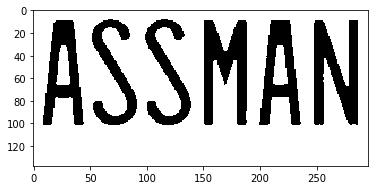

In [11]:
x, y, wcrop, hcrop = 120, 78, 50, 50
cropped_image = img.crop((x, y, w - wcrop, h - hcrop))
#show(cropped_image)
gray = cropped_image.convert('L')
bw = gray.point(lambda x: 0 if x<38 else 255, '1')
show(bw.convert('RGBA'))
cropped_image = bw.convert('RGBA')

In [25]:
boxes = pytesseract.image_to_boxes(cropped_image)
#pytesseract.image_to_string(cropped_image)
boxes

'A 9 36 45 128 0\nS 52 36 92 129 0\nS 99 36 140 129 0\nM 151 36 189 128 0\nA 200 36 237 128 0\nN 248 36 287 128 0'

In [34]:
bout = Image.new('RGBA', cropped_image.size, (255,255,255,0))
d = ImageDraw.Draw(bout)
#[[_[0]] + [int(__) for __ in _.split()[1:]] for _ in boxes.split('\n')[1:]]
[d.rectangle([int(__) for __ in _.split()[1:-1]], outline=(255, 0, 0, 255)) for _ in boxes.split('\n')]
#d.text((100, 10), "Hello", fill=(255, 0, 0, 255))

[None, None, None, None, None, None]

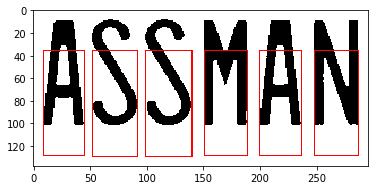

In [35]:
out = Image.alpha_composite(cropped_image, bout)
show(out)

In [36]:
def get_plate():
    refresh_rate = 750
    guesses, best_guess = {}, ""
    gcount, gmax = 0, 25
    fnt = ImageFont.truetype('Pillow/Tests/fonts/FreeMono.ttf', 40)
    x, t = 0, time.clock()
    cap = cv2.VideoCapture (0)
    while (True):
        ret, frame = cap.read()
        if not ret:
            continue
        gray = cv2.cvtColor (frame, cv2.COLOR_BGR2GRAY)
        gray = processImage(Image.fromarray(gray))

        if x%refresh_rate:
            txt = pytesseract.image_to_string(gray)
            guesses.update({txt: guesses[txt] + 1 if txt in guesses else 1})
            if txt is not '':
                gcount += 1

            bout = Image.new('RGBA', gray.size, (255,255,255,0))
            bw, bh = bout.size
            d = ImageDraw.Draw(bout)
            d.text((10,10), ascii(txt), font=fnt, fill=(255,0,0,255))

            best_guess = make_guess(guesses)
            if valid_guess(best_guess):
                d.text((10, bh - 50), best_guess, font=fnt, fill=(0,255,0,255))
            else:
                d.text((10, bh - 50), best_guess, font=fnt, fill=(255,0,0,255))
            gray = Image.alpha_composite(gray, bout)

            #print(1/(time.clock() - t))
            t = time.clock()
            if gcount > gmax:
                gcount = 0
                guesses = {}

        cv2.imshow('frame', np.array(gray.convert('RGB'))[:, :, ::-1].copy())
        if cv2.waitKey (1) & 0xFF == ord('q'):
            return best_guess
        x += 1
        if len(best_guess) > 1 and valid_guess(best_guess):
            return best_guess

In [37]:
def make_guess(g):
    km, vm = '', 0
    for k, v in g.items():
        if k is not '' and v > 1:
            if v > vm:
                vm = v
                km = k
    return km

def valid_guess(s):
    domain = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-'
    for _ in s:
        if _ not in domain:
            return False
    return True

def makeSQLtime():
    return int(time.ctime().split()[3].replace(':','')), str(datetime.datetime.today().date())

In [7]:
x, y = makeSQLtime()
y

'2019-12-08'

In [8]:
def createTransaction(guess = ""):
    global transaction_state
    inf = []
    if guess is "":
        guess = get_plate()
    cnx = cur = None
    try:
        cnx = mysql.connector.connect(**config)
    except mysql.connector.Error as err:
        if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
            print('Something is wrong with your user name or password')
        elif err.errno == errorcode.ER_BAD_DB_ERROR:
            print("Database does not exist")
        else:
            print(err)
    else:
        cur = cnx.cursor()
        #cur.execute('show databases;')
        #for row in cur.fetchall():
        #    print(row)

        cur.execute('USE usr;')
        cur.execute('SELECT * FROM user WHERE plate_num = "{}";'.format(guess))
        for row in cur.fetchall():
            inf += [row]
            print(row)

        if len(inf) is 1:
            START_TIME, START_DATE = makeSQLtime()
            cur.execute('INSERT INTO transaction (user_id, loc_id, start_time, start_date, price) VALUES ({}, {}, {}, "{}", {});'.format(
                inf[0][1], 
                THIS_LOCATION, 
                START_TIME, 
                START_DATE, 
                getLocationRate(THIS_LOCATION)))
            cnx.commit()
            transaction_state = {
                'user_id': inf[0][1],
                'loc_id': THIS_LOCATION,
                'start_time': START_TIME,
                'start_date': START_DATE,
                'valid': 1
            }

            print('Transaction created')
        else:
            print('Invalid user selection!')
            print('Prompt for user information on panel')
    finally:
        if cur:
            cur.close()
        if cnx:
            cnx.close()

In [10]:
def closeTransaction():
    global transaction_state
    if transaction_state['valid'] is 0:
        return
    
    inf = []
    print(transaction_state)
    cnx = cur = None
    try:
        cnx = mysql.connector.connect(**config)
    except mysql.connector.Error as err:
        if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
            print('Something is wrong with your user name or password')
        elif err.errno == errorcode.ER_BAD_DB_ERROR:
            print("Database does not exist")
        else:
            print(err)
    else:
        cur = cnx.cursor()

        cur.execute('USE usr;')
        cur.execute('SELECT * FROM transaction WHERE user_id = {} AND loc_id = {} AND start_time = {} AND start_date = "{}";'.format(
            transaction_state['user_id'],
            transaction_state['loc_id'],
            transaction_state['start_time'],
            transaction_state['start_date']
        ))
        for row in cur.fetchall():
            inf += [row]
            print(row)

        if len(inf) is 1:
            END_TIME, END_DATE = makeSQLtime()
            cur.execute('UPDATE transaction SET end_time = {}, end_date = "{}"  WHERE user_id = {} AND loc_id = {} AND start_time = {} AND start_date = "{}";'.format(
                END_TIME,
                END_DATE,
                transaction_state['user_id'],
                THIS_LOCATION,
                transaction_state['start_time'],
                transaction_state['start_date']
            ))
            cnx.commit()
            transaction_state = {
                'user_id': 0,
                'loc_id': 0,
                'start_time': 0,
                'valid': 0
            }

            print('Transaction updated')
        else:
            print('Invalid user selection!')
            print('Prompt for user information on panel')
    finally:
        if cur:
            cur.close()
        if cnx:
            cnx.close()
  

In [11]:
def getLocationRate(loc_id):
    dat = []
    cnx = cur = None
    try:
        cnx = mysql.connector.connect(**config)
    except mysql.connector.Error as err:
        if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
            print('Something is wrong with your user name or password')
        elif err.errno == errorcode.ER_BAD_DB_ERROR:
            print("Database does not exist")
        else:
            print(err)
    else:
        cur = cnx.cursor()

        cur.execute('USE usr;')
        cur.execute('SELECT cost FROM rate WHERE loc_id = {};'.format(loc_id))
        for row in cur.fetchall():
            dat += [row]
            #print(row)
    finally:
        if cur:
            cur.close()
        if cnx:
            cnx.close()
    return dat[0][0]

In [12]:
def getCostByLicense(license):
    dat = []
    cnx = cur = None
    try:
        cnx = mysql.connector.connect(**config)
    except mysql.connector.Error as err:
        if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
            print('Something is wrong with your user name or password')
        elif err.errno == errorcode.ER_BAD_DB_ERROR:
            print("Database does not exist")
        else:
            print(err)
    else:
        cur = cnx.cursor()

        cur.execute('USE usr;')
        cur.execute('SELECT trans_id, loc_id, start_date, start_time, MINUTE(TIMEDIFF(cast(concat(end_date, " ", end_time) as datetime), cast(concat(start_date, " ", start_time) as datetime)))*Price AS Cost FROM user NATURAL JOIN transaction WHERE plate_num = "{}";'.format(license))
        for row in cur.fetchall():
            dat += [row]
            #print(row)
    finally:
        if cur:
            cur.close()
        if cnx:
            cnx.close()
    return dat

In [22]:
createTransaction(guess = "ABC-1001")

('ABC-1001', 1, 'Honda', 'Odyssey', 'Gray')
Transaction created


In [38]:
createTransaction()

2003: Can't connect to MySQL server on '35.193.20.163:3306' (101 Network is unreachable)


In [23]:
closeTransaction()

{'user_id': 1, 'loc_id': 1, 'start_time': 130559, 'start_date': '2019-03-24', 'valid': 1}
(11, 1, 1, datetime.timedelta(0, 47159), datetime.date(2019, 3, 24), None, None, -200)
Transaction updated


In [ ]:
d = getCostByLicense('ABC-1001')
row_titles = [["Transaction ID", "Location ID", "Start Date", "Start Time", "Total Cost"]]
[[print("{:>20}".format(str(__)), end = '\t') for __ in _] + [print()] for _ in row_titles + d];None

In [ ]:
transaction_state